In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# 1. Đọc dữ liệu
train_df = pd.read_csv('../Dataset/712/train.csv')
valid_df = pd.read_csv('../Dataset/712/valid.csv')
test_df = pd.read_csv('../Dataset/712/test.csv')

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)

Train: (31362, 17)
Valid: (4480, 17)
Test: (8962, 17)


In [5]:
# 2. Hàm tiền xử lý
def preprocess(df, encoders=None, scaler=None, is_train=True):
    df = df.copy()

    # Tính Revenue
    df['Revenue'] = df['Quantity'] * df['UnitPrice'] * (1 - df['Discount'])

    # Các cột
    categorical_cols = ['Country', 'Category', 'SalesChannel', 'PaymentMethod']
    numerical_cols = ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost']
    target_col = 'Revenue'
    
    # Encode categorical
    if is_train:
        encoders = {col: LabelEncoder().fit(df[col].astype(str)) for col in categorical_cols}
    for col in categorical_cols:
        df[col] = encoders[col].transform(df[col].astype(str))
    
    # Scale numerical
    if is_train:
        scaler = StandardScaler().fit(df[numerical_cols])
    df[numerical_cols] = scaler.transform(df[numerical_cols])
    
    # Features and Target
    X = df[categorical_cols + numerical_cols]
    y = df[target_col] if target_col in df.columns else None
    
    return X, y, encoders, scaler

In [6]:
X_train, y_train, encoders, scaler = preprocess(train_df, is_train=True)
X_valid, y_valid, _, _ = preprocess(valid_df, encoders, scaler, is_train=False)
X_test, _, _, _ = preprocess(test_df, encoders, scaler, is_train=False)

In [7]:
# Chuyển đổi dữ liệu thành DMatrix cho XGBoost
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
valid_dmatrix = xgb.DMatrix(X_valid, label=y_valid)
test_dmatrix = xgb.DMatrix(X_test)

# Cấu hình các tham số cho mô hình XGBoost
params = {
    'objective': 'reg:squarederror',  # Để làm bài toán hồi quy
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'silent': 1
}

# Huấn luyện mô hình XGBoost
num_round = 100  # Số vòng huấn luyện
evals = [(train_dmatrix, 'train'), (valid_dmatrix, 'eval')]
model = xgb.train(params, train_dmatrix, num_round, evals, early_stopping_rounds=10)


[0]	train-rmse:768.83874	eval-rmse:785.17877
[1]	train-rmse:696.13713	eval-rmse:711.00176
[2]	train-rmse:630.52044	eval-rmse:644.63903
[3]	train-rmse:571.28355	eval-rmse:584.63140


[4]	train-rmse:517.81552	eval-rmse:530.26158
[5]	train-rmse:469.61396	eval-rmse:481.11702
[6]	train-rmse:425.97661	eval-rmse:436.87289
[7]	train-rmse:386.22694	eval-rmse:396.31491
[8]	train-rmse:350.57384	eval-rmse:360.20921
[9]	train-rmse:318.36710	eval-rmse:327.40408
[10]	train-rmse:289.10579	eval-rmse:297.56971
[11]	train-rmse:262.54045	eval-rmse:270.66011
[12]	train-rmse:238.52848	eval-rmse:246.31684
[13]	train-rmse:216.94030	eval-rmse:224.23743
[14]	train-rmse:197.17968	eval-rmse:204.14746
[15]	train-rmse:179.40743	eval-rmse:185.91053
[16]	train-rmse:163.36739	eval-rmse:169.56881
[17]	train-rmse:148.78022	eval-rmse:154.72908
[18]	train-rmse:135.81770	eval-rmse:141.47624
[19]	train-rmse:123.88213	eval-rmse:129.42113
[20]	train-rmse:113.09471	eval-rmse:118.46418
[21]	train-rmse:103.49555	eval-rmse:108.60931
[22]	train-rmse:94.58712	eval-rmse:99.41170
[23]	train-rmse:86.69989	eval-rmse:91.32218
[24]	train-rmse:79.39798	eval-rmse:83.80257
[25]	train-rmse:72.89391	eval-rmse:77.08624
[2

c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [13:49:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  self.starting_round = model.num_boosted_rounds()


[35]	train-rmse:34.85750	eval-rmse:37.84893
[36]	train-rmse:32.91925	eval-rmse:35.87025
[37]	train-rmse:31.20162	eval-rmse:34.11181
[38]	train-rmse:29.69357	eval-rmse:32.59301
[39]	train-rmse:28.32388	eval-rmse:31.17825
[40]	train-rmse:27.09423	eval-rmse:29.86998
[41]	train-rmse:26.02413	eval-rmse:28.76413
[42]	train-rmse:25.10635	eval-rmse:27.80678
[43]	train-rmse:24.31031	eval-rmse:26.96209
[44]	train-rmse:23.62436	eval-rmse:26.24147
[45]	train-rmse:23.01224	eval-rmse:25.59142
[46]	train-rmse:22.48645	eval-rmse:25.03716
[47]	train-rmse:22.02716	eval-rmse:24.54432
[48]	train-rmse:21.54221	eval-rmse:23.99608
[49]	train-rmse:21.18620	eval-rmse:23.61131
[50]	train-rmse:20.86460	eval-rmse:23.26091
[51]	train-rmse:20.51029	eval-rmse:22.85347
[52]	train-rmse:20.24904	eval-rmse:22.54489
[53]	train-rmse:20.03853	eval-rmse:22.31523
[54]	train-rmse:19.84049	eval-rmse:22.09842
[55]	train-rmse:19.67496	eval-rmse:21.91468
[56]	train-rmse:19.51932	eval-rmse:21.73394
[57]	train-rmse:19.38693	eval-rm

In [8]:
# Dự đoán trên tập valid
valid_preds = model.predict(valid_dmatrix)

# Đánh giá mô hình trên tập valid
val_mae = mean_absolute_error(y_valid, valid_preds)
val_mse = mean_squared_error(y_valid, valid_preds)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_valid, valid_preds)
print(f"Val MAE: {val_mae:.2f}, Val MSE: {val_mse:.2f}, Val RMSE: {val_rmse:.2f}, Val R²: {val_r2:.2f}")

# Dự đoán trên tập test
test_preds = model.predict(test_dmatrix)

# Tính lại cột 'Revenue' cho test_df 
test_df['Revenue'] = test_df['Quantity'] * test_df['UnitPrice'] * (1 - test_df['Discount'])

test_true = test_df['Revenue'].values 
test_mae = mean_absolute_error(test_true, test_preds)
test_mse = mean_squared_error(test_true, test_preds)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_true, test_preds)
print(f"Test MAE: {test_mae:.2f}, Test MSE: {test_mse:.2f}, Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

Val MAE: 13.18, Val MSE: 340.08, Val RMSE: 18.44, Val R²: 1.00
Test MAE: 13.52, Test MSE: 365.48, Test RMSE: 19.12, Test R²: 1.00


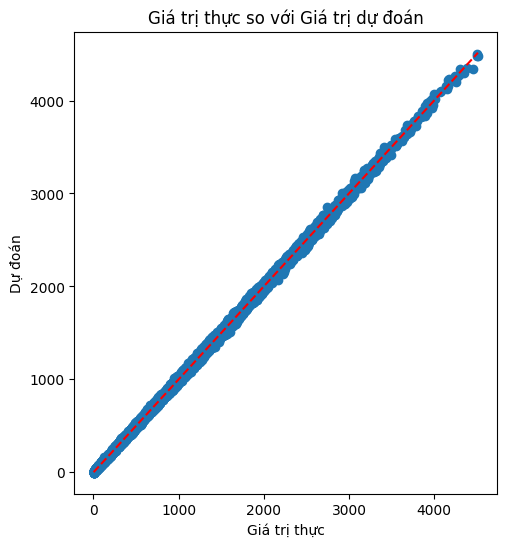

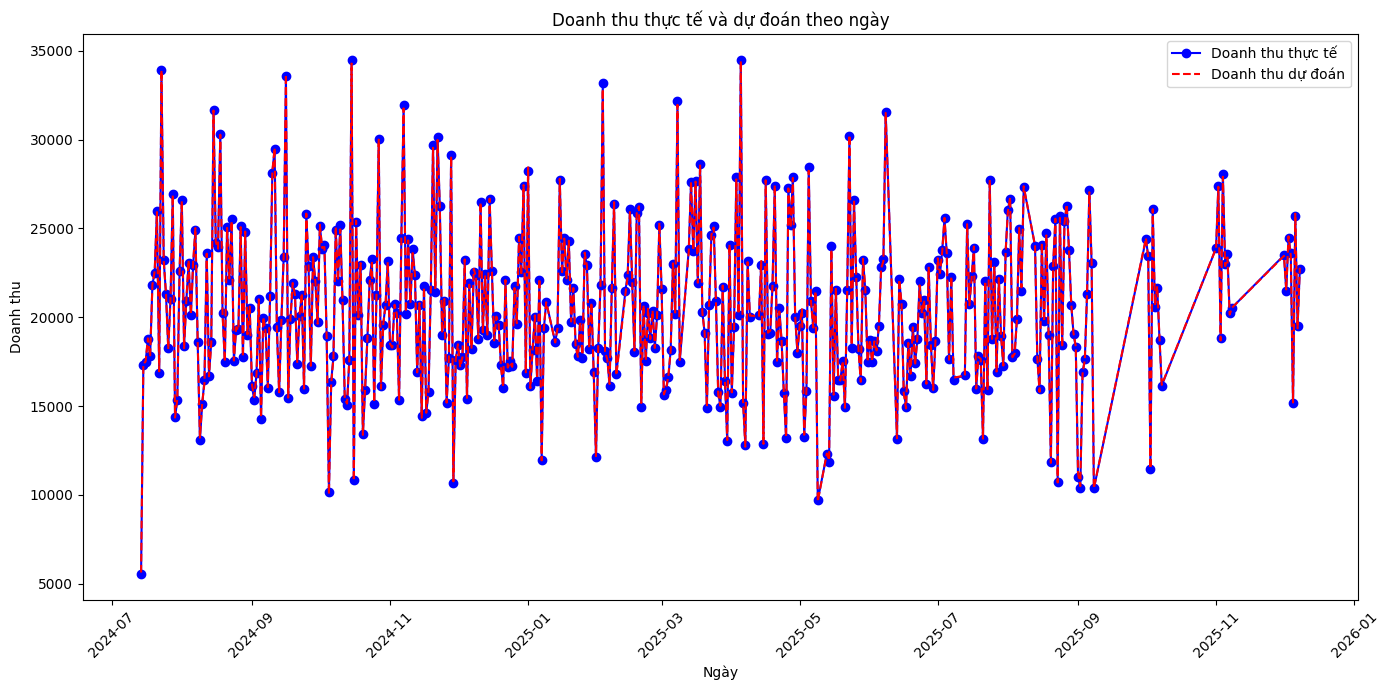

In [9]:
# Vẽ đồ thị thực tế và dự đoán
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(test_true, test_preds)
plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], color='red', linestyle='--')
plt.xlabel('Giá trị thực')
plt.ylabel('Dự đoán')
plt.title('Giá trị thực so với Giá trị dự đoán')

# Nhóm dữ liệu theo ngày và vẽ đồ thị doanh thu thực tế và dự đoán
if 'InvoiceDate' in test_df.columns:
    test_df['InvoiceDate'] = pd.to_datetime(test_df['InvoiceDate'])
    
    # Dự đoán doanh thu từ mô hình
    test_df['PredictedRevenue'] = test_preds
    
    # Nhóm dữ liệu theo ngày
    daily_sales = test_df.groupby(test_df['InvoiceDate'].dt.date).agg({'Revenue': 'sum', 'PredictedRevenue': 'sum'}).reset_index()

    # Vẽ đồ thị doanh thu thực tế và dự đoán theo ngày
    plt.figure(figsize=(14, 7))
    plt.plot(daily_sales['InvoiceDate'], daily_sales['Revenue'], label='Doanh thu thực tế', color='blue', marker='o')
    plt.plot(daily_sales['InvoiceDate'], daily_sales['PredictedRevenue'], label='Doanh thu dự đoán', color='red', linestyle='--')
    plt.xlabel('Ngày')
    plt.ylabel('Doanh thu')
    plt.title('Doanh thu thực tế và dự đoán theo ngày')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()